# Checking my maximum-counting function

Jack Dinsmore, July 2020

In _cluster\-lightcurves\-series.ipynb_, I defined a function which counts the number of maxima in an image. I want to check to make sure it works. Here are some tests I will run.

1. A uniformly random image. The number of maximal pixels should be 1/5 of the image &mdash; that's 20\%. See appendix for why.
1. A nan wall added to a uniformly random image. Expect 20\%, plus a little bit from edge effects.
1. A gaussian of rotation. There should be exactly one maximal pixel.
1. A horizontal gradient. There should be exactly no maximal pixels.

It passes all the tests, so I think it's right.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

IMAGE_SIZE = 180
LOWER_LIMIT = 0

def countMaxima(data):
    stars = 0
    
    def getValue(x, y):
        if x < 0 or x >= data.shape[0] or y < 0 or y >= data.shape[0]:
            return 0 # Count this pixel as automatically smaller than everything else
        if np.isnan(data[x][y]):
            return 0 # Count this pixel as automatically smaller than everything else.
        if data[x][y] < LOWER_LIMIT:
            return 0 # Count this pixel as automatically smaller than everything else.
        return data[x][y]
        
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = getValue(x, y-1)
            down = getValue(x, y+1)
            left = getValue(x-1, y)
            right = getValue(x+1, y)
            if b > max(up, down, left, right):
                stars += 1
    return stars

## Test 1: a random image.

19.959876543209877\%. Should be close to 20\%.


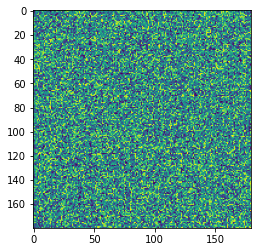

In [2]:
img = np.random.rand(IMAGE_SIZE, IMAGE_SIZE)
numMaxima = countMaxima(img)
notNanMask = ~np.isnan(img)
notEdgeMask = img > LOWER_LIMIT
numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
print("{0}\%. Should be close to 20\%.".format(numMaxima / numPixels * 100))
plt.imshow(img);

## Test 2: replace some random pixels with nans

20.22222222222222\%. Should be close to 20\%.


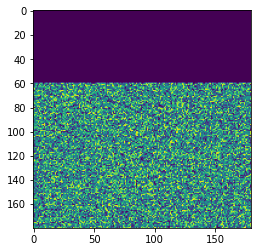

In [3]:
img = np.random.rand(IMAGE_SIZE, IMAGE_SIZE)
for x in range(0, IMAGE_SIZE // 3):
    for y in range(0, img.shape[1]):
        img[x][y] = 0
numMaxima = countMaxima(img)
notNanMask = ~np.isnan(img)
notEdgeMask = img > LOWER_LIMIT
numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
print("{0}\%. Should be close to 20\%.".format(numMaxima / numPixels * 100))
plt.imshow(img);

## Test 3: Gaussian of rotation.

1. Should be 1.


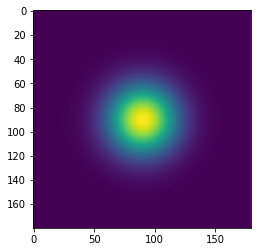

In [4]:
def gauss(r2):
    sigma2 = 400
    return 1 / (2 * 3.14159 * sigma2)**0.5 * 2.71828**(- 1 / 2 * r2 / sigma2)

img = []
for x in range(0, IMAGE_SIZE):
    for y in range(0, IMAGE_SIZE):
        distance2 = (x - IMAGE_SIZE // 2)**2 + (y - IMAGE_SIZE // 2)**2
        img.append(gauss(distance2))
img = np.array(img).reshape(IMAGE_SIZE, IMAGE_SIZE)
numMaxima = countMaxima(img)
notNanMask = ~np.isnan(img)
notEdgeMask = img > LOWER_LIMIT
numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
print("{0}. Should be 1.".format(numMaxima))
plt.imshow(img);

## Test 4. Gradient.

0. Should be 0.


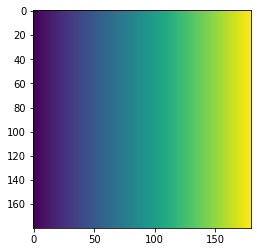

In [5]:
img = []
for x in range(0, IMAGE_SIZE):
    for y in range(0, IMAGE_SIZE):
        img.append(y / IMAGE_SIZE)
img = np.array(img).reshape(IMAGE_SIZE, IMAGE_SIZE)
numMaxima = countMaxima(img)
notNanMask = ~np.isnan(img)
notEdgeMask = img > LOWER_LIMIT
numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
print("{0}. Should be 0.".format(numMaxima))
plt.imshow(img);

## Appendix. Why should 1/5 of the pixels in a large, uniformly random image be maxima?

Consider an image whose pixels have a flux ranging from zero to one and which is large enough for the center pixels, which have four neighbors, to dominate the edge and corner pixels, which have fewer neighbors.

Let $x \in [0, 1]$ be the flux of a certain pixel which has $f \in \mathbb{N}$ neighbors. For a uniformly random image, $x$ has a prior probability distribution of $p(x)dx = dx$. Let $N$ be an indicator random variable which is 1 if $x$ is a maximum and zero otherwise. The probability that $x$ is greater than a given neighbor is $x$, and since $x$ must be greater than all its neighbors for $N$ to be 1, the probability that $N=1$ is $P(N=1 | x) = x^f$.

The expected value for $N$ is $E(N) = 0 \cdot P(N=0) + 1 \cdot P(N= 1) = P(N=1)$, which is
$$E(N) = \int_0^1 P(N=1 | x) p(x) dx = \int_0^1 x^f dx = \frac{1}{f + 1}.$$
Note that for a two-dimensional image, $f=4$, and $E(N) = 0.2$

In the large-image case, the expected value of $N$ is equal to the expected fraction of pixels that are maxima because all the pixels will have the same probability distribution and the same number of neighbors. Hence, the fraction of maximal pixels in a two-dimensional large image is $\frac{1}{5}$.